In [1]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np
import seaborn as sns
#import spacy

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyLDAvis
!pwd

/content


In [3]:
#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

In [4]:
## loading df that has data for the specific periods of interest     ('2020-01-01', '2020-05-31'),('2020-10-01', '2021-01-31'),('2021-11-01', '2022-01-31'),('2022-11-01','2023-01-31')

In [5]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'
# Load the DataFrame from the CSV file
df = pd.read_csv(path)

In [6]:
df.head()

,created_utc,label,score,cleaned_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...
3,2020-05-31,mild neu,0.576460,thanks
4,2020-05-31,mild neu,0.629136,bigger w


In [7]:
!pip install contractions

In [8]:

# import nltk
# nltk.download('punkt_tab')
!pip install -U spacy
#torch transformers

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 re

In [9]:
df.shape[0]

87034

In [10]:
#drop NA
# drop any rows where cleaned_text isn’t a real string
df = df.dropna(subset=['cleaned_text'])
df.shape[0]

86446

In [11]:
# ## Data cleaning
# import re, string
# import pandas as pd
# import contractions
# from collections import Counter
# import nltk
# from nltk.corpus     import stopwords
# from nltk.tokenize   import word_tokenize
# from nltk.stem       import WordNetLemmatizer




# #  Convert any timestamp column now if you’ll need it:
# df['created_utc'] = pd.to_datetime(df['created_utc'])

# # Define your full-clean function once
# nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def full_clean(doc):
#     doc = re.sub(r'\s+', ' ', doc).strip()
#     doc = doc.lower()
#     doc = re.sub(r'http\S+|www\.\S+', '', doc)
#     doc = re.sub(r'<.*?>',          '', doc)
#     doc = re.sub(r'@\w+|#\w+',      '', doc)
#     doc = contractions.fix(doc)
#     doc = doc.translate(str.maketrans('', '', string.punctuation))
#     doc = re.sub(r'\d+', '', doc)
#     tokens = [
#         lemmatizer.lemmatize(t)
#         for t in word_tokenize(doc)
#         if t not in stop_words and len(t)>2
#     ]
#     return tokens

# #  Apply it once to every row
# df['tokens']     = df['cleaned_text'].apply(full_clean)
# df['final_text'] = df['tokens'].str.join(' ')


# df[['created_utc','score','final_text','tokens']].head()
## Data Cleaning with spaCy
import re, string
import pandas as pd
import contractions
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_trf")
# Convert timestamp column
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define full-clean function using spaCy
def full_clean_spacy(doc):
    # Basic regex cleaning
    doc = re.sub(r'\s+', ' ', doc).strip()
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\.\S+', '', doc)
    doc = re.sub(r'<.*?>',          '', doc)
    doc = re.sub(r'@\w+|#\w+',      '', doc)
    doc = contractions.fix(doc)
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = re.sub(r'\d+', '', doc)

    # Process with spaCy
    spacy_doc = nlp(doc)

    # Lemmatize, remove stopwords and short tokens
    tokens = [
        token.lemma_
        for token in spacy_doc
        if not token.is_stop and not token.is_punct and len(token) > 2
    ]
    return tokens

# Apply to each row
df['tokens']     = df['cleaned_text'].apply(full_clean_spacy)
df['final_text'] = df['tokens'].str.join(' ')

# Preview
df[['created_utc','score','final_text','tokens']].head()


,created_utc,score,final_text,tokens
0,2020-05-31,0.569819,ill pay mosaic,"[ill, pay, mosaic]"
1,2020-05-31,0.617377,redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo..."
2,2020-05-31,0.610706,sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula..."
3,2020-05-31,0.576460,thank,[thank]
4,2020-05-31,0.629136,big,[big]


In [12]:
df.shape[0]

86446

In [ ]:
# Filter the DataFrame
high_pos_df = df[df['label'] == 'high pos']

# Convert the 'created_utc' column to datetime
high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# Define your date range
start_date = '2020-10-01'
end_date = '2021-01-31'

# Filter the DataFrame for entries within the specified date range
high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_pos_df.head()

<ipython-input-13-2d9027c8b960>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
28678,2021-01-31,high pos,0.974968,well thats good news,"[good, news]",good news
28683,2021-01-31,high pos,0.786084,arizona fun sept want within hiking relaxingpo...,"[arizona, fun, sept, want, hike, relaxingpools...",arizona fun sept want hike relaxingpoolspa drive
28700,2021-01-31,high pos,0.821570,marriott ko olina moment typing kiddos pool bl...,"[marriott, olina, moment, type, kiddo, pool, b...",marriott olina moment type kiddo pool blast su...
28703,2021-01-31,high pos,0.773547,jumping say much love hawaii impressive guy ta...,"[jumping, love, hawaii, impressive, guy, take,...",jumping love hawaii impressive guy take seriou...
28708,2021-01-30,high pos,0.761419,op staying night mauikaanapali timeshare room ...,"[staying, night, mauikaanapali, timeshare, roo...",staying night mauikaanapali timeshare room kit...


In [ ]:
high_pos_df.shape[0]

1833

         token  count
0         good    700
1        great    464
2        thank    407
3         stay    336
4        point    329
5         look    318
6         like    305
7        night    291
8         nice    290
9         time    269
10        trip    253
11       hotel    246
12      flight    242
13         day    229
14          go    225
15        book    213
16       beach    208
17      pretty    204
18        well    195
19       think    194
20         get    187
21       hyatt    178
22         way    177
23         fly    177
24        year    174
25        want    171
26      travel    163
27  definitely    159
28        room    158
29        find    157


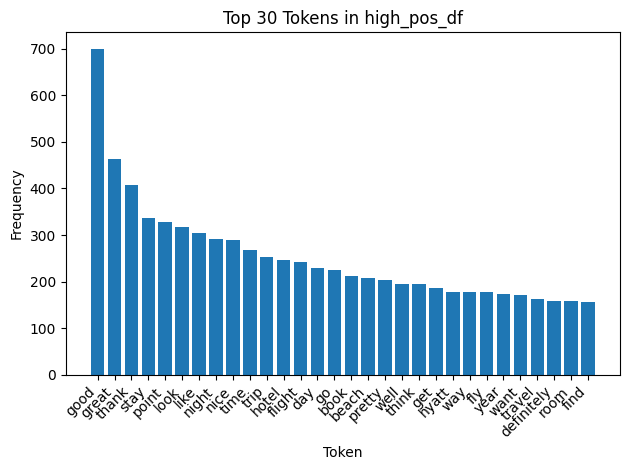

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

#  Flatten your tokens into one long list
all_tokens = [t for toks in high_pos_df['tokens'] for t in toks]

# Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

#Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_pos_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_pos_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_pos_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


36521 words total, with a vocabulary size of 5026
Max reddit post length is 251 tokens
Mean reddit post length is 19.92 tokens
Median reddit post length is 12 tokens


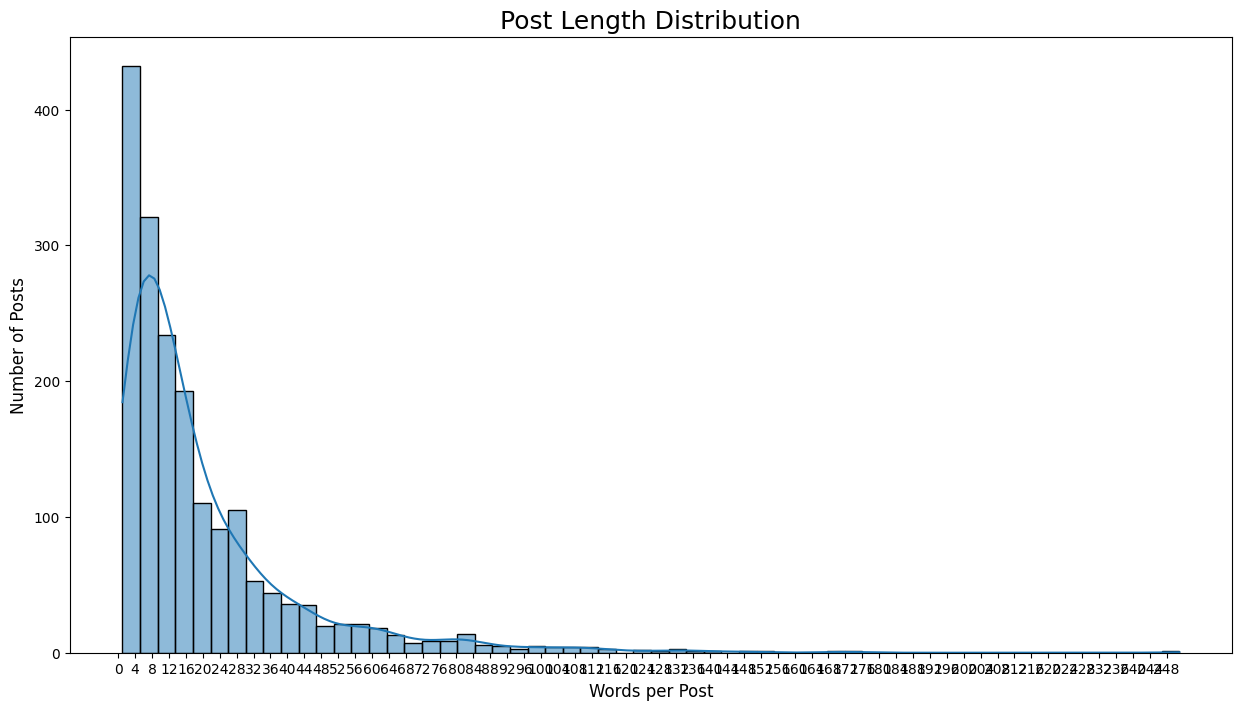

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [ ]:


!pip install  gensim

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Prepare your list-of-lists from the `tokens` column
texts = high_pos_df['tokens'].tolist()

#  Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# Apply bigram and trigram transforms
high_pos_df['bigram_tokens']   = high_pos_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_pos_df['trigram_tokens']  = high_pos_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_pos_df['bigram_text']   = high_pos_df['bigram_tokens'].str.join(' ')
# high_pos_df['trigram_text']  = high_pos_df['trigram_tokens'].str.join(' ')

# Inspect
print(high_pos_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
28678                                       [good, news]   
28683  [arizona, fun, sept, want, hike, relaxingpools...   
28700  [marriott, olina, moment, type, kiddo, pool, b...   
28703  [jumping, love, hawaii, impressive, guy, take,...   
28708  [staying, night, mauikaanapali, timeshare, roo...   

                                           bigram_tokens  \
28678                                       [good, news]   
28683  [arizona, fun, sept, want, hike, relaxingpools...   
28700  [marriott, olina, moment, type, kiddo, pool, b...   
28703  [jumping, love, hawaii, impressive, guy, take,...   
28708  [staying, night, mauikaanapali, timeshare, roo...   

                                          trigram_tokens  
28678                                       [good, news]  
28683  [arizona, fun, sept, want, hike, relaxingpools...  
28700  [marriott, olina, moment, type, kiddo, pool, b...  
28703  [jumping, love, hawaii, impressive,

In [ ]:
#  Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# Flag rows
high_pos_df['has_bigrams']  = high_pos_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_pos_df['has_trigrams'] = high_pos_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# Count
rows_with_bigrams  = high_pos_df['has_bigrams'].sum()
rows_with_trigrams = high_pos_df['has_trigrams'].sum()
rows_with_none     = (~high_pos_df['has_bigrams'] & ~high_pos_df['has_trigrams']).sum()

#  Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   456
Rows with trigrams:  11
Rows with no n-grams: 1377


In [ ]:
high_pos_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28678,2021-01-31,high pos,0.974968,well thats good news,"[good, news]",good news,"[good, news]","[good, news]",False,False
28683,2021-01-31,high pos,0.786084,arizona fun sept want within hiking relaxingpo...,"[arizona, fun, sept, want, hike, relaxingpools...",arizona fun sept want hike relaxingpoolspa drive,"[arizona, fun, sept, want, hike, relaxingpools...","[arizona, fun, sept, want, hike, relaxingpools...",False,False
28700,2021-01-31,high pos,0.821570,marriott ko olina moment typing kiddos pool bl...,"[marriott, olina, moment, type, kiddo, pool, b...",marriott olina moment type kiddo pool blast su...,"[marriott, olina, moment, type, kiddo, pool, b...","[marriott, olina, moment, type, kiddo, pool, b...",False,False
28703,2021-01-31,high pos,0.773547,jumping say much love hawaii impressive guy ta...,"[jumping, love, hawaii, impressive, guy, take,...",jumping love hawaii impressive guy take seriou...,"[jumping, love, hawaii, impressive, guy, take,...","[jumping, love, hawaii, impressive, guy, take,...",False,False
28708,2021-01-30,high pos,0.761419,op staying night mauikaanapali timeshare room ...,"[staying, night, mauikaanapali, timeshare, roo...",staying night mauikaanapali timeshare room kit...,"[staying, night, mauikaanapali, timeshare, roo...","[staying, night, mauikaanapali, timeshare, roo...",False,False


In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_pos_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_pos_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 1833
Number of rows in 'trigram_tokenized' column: 1833


In [ ]:
import itertools
from collections import Counter

#  Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_pos_df['trigram_tokens'])

# Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

#  Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 4

Most common trigrams:
ziva_puerto_vallarta: 5
playa_del_carmen: 4
zilara_cap_cana: 3
pool_hot_tub: 3


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                        chunksize=200,
#                                        passes=260,
#                                         iterations=100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_pos_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

#
texts = high_pos_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 12)  # Adjust the range based on your needs
chunksize_range = [ 200]
passes_range = [50,200,260]
iterations_range = [50, 100, 170]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta} ")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha', 'eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 50, Perplexity: -7.2615, Coherence: 0.6264, Alpha: [0.1305     0.07235616], Eta: [78.327896    1.1876087   0.48764116 ...  0.57770014  0.57770014
  0.57769865] 


Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 100, Perplexity: -7.2609, Coherence: 0.6264, Alpha: [0.1297866  0.06999488], Eta: [78.270874    1.1846491   0.4880731  ...  0.57827187  0.57827187
  0.5782704 ] 


Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 170, Perplexity: -7.2607, Coherence: 0.6264, Alpha: [0.12850712 0.06908299], Eta: [78.329956    1.1859862   0.48822019 ...  0.57846785  0.57846785
  0.5784663 ] 


Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 50, Perplexity: -7.2323, Coherence: 0.6291, Alpha: [0.09088123 0.05068585], Eta: [83.99165    1.2240617  0.5184186 ...  0.6078684  0.6078684  0.6078676] 
Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 100, Perplexity: -7.2327, Coherence: 0.6291, Alpha: [0.09281409 0.05125819], Eta: [83.60308     1.2209347   0.5178748  ...  0.60715824  0.60715824
  0.6071575 ] 


Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 170, Perplexity: -7.2325, Coherence: 0.6291, Alpha: [0.09274263 0.05084476], Eta: [83.6127      1.2215      0.5179242  ...  0.60722244  0.60722244
  0.60722166] 


Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 50, Perplexity: -7.2295, Coherence: 0.6291, Alpha: [0.08856783 0.04964447], Eta: [84.42226     1.2299206   0.52101964 ...  0.6103818   0.6103818
  0.6103812 ] 
Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 100, Perplexity: -7.2297, Coherence: 0.6291, Alpha: [0.09080807 0.04999846], Eta: [83.99927     1.2277005   0.52060354 ...  0.6098391   0.6098391
  0.60983825] 


Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 170, Perplexity: -7.2293, Coherence: 0.6291, Alpha: [0.08818324 0.04841497], Eta: [84.2918      1.2295982   0.52104723 ...  0.61041665  0.61041665
  0.61041594] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 50, Perplexity: -7.3708, Coherence: 0.5109, Alpha: [0.14884095 0.18576197 0.37944496], Eta: [37.842976    0.6273955   0.29323    ...  0.31682795  0.31682795
  0.31698066] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 100, Perplexity: -7.4055, Coherence: 0.4717, Alpha: [0.19663492 0.3300177  1.0109268 ], Eta: [3.5376396  0.35227287 0.2880276  ... 0.31186748 0.31186748 0.33864275] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 170, Perplexity: -7.3838, Coherence: 0.5444, Alpha: [0.23555043 0.1492331  1.4040323 ], Eta: [1.9894847  0.354267   0.2967959  ... 0.3144067  0.3144067  0.31269437] 
Num Topics: 3, Chunksize: 200, Passes: 200, Iterations: 50, Perplexity: -7.3077, Coherence: 0.5319, Alpha: [0.096

Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 50, Perplexity: -7.2587, Coherence: 0.6291, Alpha: [0.14022943 0.06890529], Eta: [77.248215    1.0636092   0.48985273 ...  0.58062655  0.58062655
  0.58062506] 
Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 100, Perplexity: -7.2560, Coherence: 0.6291, Alpha: [0.12516817 0.05938   ], Eta: [78.332596    1.1475443   0.49255738 ...  0.58422947  0.58422947
  0.58422816] 


Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 170, Perplexity: -7.2559, Coherence: 0.6291, Alpha: [0.12495285 0.05920969], Eta: [78.34541     1.1461107   0.4926252  ...  0.5843199   0.5843199
  0.58431864] 
Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 50, Perplexity: -7.2308, Coherence: 0.6291, Alpha: [0.09276844 0.04846514], Eta: [83.01546     1.2164316   0.51938504 ...  0.6091235   0.6091235
  0.60912275] 


Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 100, Perplexity: -7.2305, Coherence: 0.6291, Alpha: [0.09314583 0.04778428], Eta: [82.976616    1.2176887   0.51952684 ...  0.60930747  0.60930747
  0.60930663] 


Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 170, Perplexity: -7.2305, Coherence: 0.6291, Alpha: [0.09278247 0.04765729], Eta: [82.98916    1.2183739  0.519553  ...  0.6093417  0.6093417  0.6093409] 
Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 50, Perplexity: -7.2281, Coherence: 0.6184, Alpha: [0.0905983  0.04780519], Eta: [83.51701    1.2220312  0.5219526 ...  0.6115921  0.6115921  0.6115914] 


Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 100, Perplexity: -7.2281, Coherence: 0.6301, Alpha: [0.09168462 0.04737949], Eta: [83.39135     1.2236949   0.52197546 ...  0.6116206   0.6116206
  0.61162   ] 


Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 170, Perplexity: -7.2280, Coherence: 0.6301, Alpha: [0.09167993 0.04737672], Eta: [83.39138     1.2236955   0.52197564 ...  0.61162096  0.61162096
  0.61162025] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 50, Perplexity: -7.3480, Coherence: 0.5449, Alpha: [0.6130001  0.16654237 0.05073001], Eta: [3.0093951  0.3553868  0.29455036 ... 0.31688923 0.31688923 0.31690517] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 100, Perplexity: -7.3467, Coherence: 0.5776, Alpha: [0.58961177 0.13744044 0.04364843], Eta: [2.8956804  0.35445246 0.29698035 ... 0.31939453 0.31939453 0.31939876] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 170, Perplexity: -7.3469, Coherence: 0.5936, Alpha: [0.6038176  0.13221757 0.04570907], Eta: [2.3687031  0.35461318 0.29766312 ... 0.31971475 0.31971475 0.31971812] 
Num Topics: 3, Chunksize: 200, Passes: 200, Iterations: 50, Perplexity: -7.3068, Coherence: 0.5451, Alpha: [0.25639173 0

Num Topics: 11, Chunksize: 200, Passes: 260, Iterations: 170, Perplexity: -7.8416, Coherence: 0.5049, Alpha: [3.0316374  0.19051927 0.15232849 0.32188493 0.6091609  0.16033384
 0.47077048 0.2978003  0.82711774 0.656637   4.219652  ], Eta: [0.09099704 0.08784798 0.08690313 ... 0.0874568  0.0874568  0.08745805] 


Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 50, Perplexity: -7.2610, Coherence: 0.6291, Alpha: [0.07317523 0.1366124 ], Eta: [77.67522     1.1749587   0.48765647 ...  0.57771575  0.57771575
  0.57771426] 
Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 100, Perplexity: -7.2610, Coherence: 0.6291, Alpha: [0.07306151 0.13662097], Eta: [77.62922     1.1755675   0.48762265 ...  0.5776703   0.5776703
  0.5776688 ] 


Num Topics: 2, Chunksize: 200, Passes: 50, Iterations: 170, Perplexity: -7.2609, Coherence: 0.6291, Alpha: [0.07292084 0.13675874], Eta: [77.60101     1.176347    0.48766673 ...  0.57772857  0.57772857
  0.57772714] 


Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 50, Perplexity: -7.2330, Coherence: 0.6174, Alpha: [0.05314189 0.09708545], Eta: [83.01783     1.2052627   0.517242   ...  0.60633266  0.60633266
  0.6063318 ] 
Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 100, Perplexity: -7.2327, Coherence: 0.6174, Alpha: [0.05259173 0.09603035], Eta: [83.12189     1.2057054   0.5173212  ...  0.606436    0.606436
  0.60643524] 


Num Topics: 2, Chunksize: 200, Passes: 200, Iterations: 170, Perplexity: -7.2325, Coherence: 0.6174, Alpha: [0.05213597 0.09527764], Eta: [83.08462    1.2065011  0.517508  ...  0.6066793  0.6066793  0.6066785] 


Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 50, Perplexity: -7.2300, Coherence: 0.6174, Alpha: [0.05125324 0.09351254], Eta: [83.5804      1.2127792   0.52012646 ...  0.60921794  0.60921794
  0.6092171 ] 
Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 100, Perplexity: -7.2295, Coherence: 0.6174, Alpha: [0.04993284 0.0907905 ], Eta: [83.82532     1.2139808   0.520496   ...  0.60969913  0.60969913
  0.6096984 ] 


Num Topics: 2, Chunksize: 200, Passes: 260, Iterations: 170, Perplexity: -7.2294, Coherence: 0.6174, Alpha: [0.04996127 0.09098138], Eta: [83.71669     1.2141712   0.5204996  ...  0.60970354  0.60970354
  0.6097027 ] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 50, Perplexity: -7.3430, Coherence: 0.5416, Alpha: [0.20466624 0.49015597 0.0403053 ], Eta: [3.3754454  0.3595026  0.29385933 ... 0.31711403 0.31711403 0.31715983] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 100, Perplexity: -7.3486, Coherence: 0.5287, Alpha: [0.23146531 0.54406077 0.05514394], Eta: [3.228209   0.35136572 0.28999218 ... 0.31259963 0.31259963 0.31267196] 
Num Topics: 3, Chunksize: 200, Passes: 50, Iterations: 170, Perplexity: -7.3507, Coherence: 0.5228, Alpha: [0.23202862 0.56704235 0.06487249], Eta: [3.16406    0.35092154 0.28792116 ... 0.3102845  0.3102845  0.31035766] 
Num Topics: 3, Chunksize: 200, Passes: 200, Iterations: 50, Perplexity: -7.3085, Coherence: 0.5628, Alpha: [0.12139025 0

In [ ]:
# Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

#  Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")

Re-fitted Optimal Model:
 Coherence: 0.6301
 Perplexity: -7.2280
 Alpha (per topic): [0.09167993 0.04737672]
 Eta   (per word):  [83.39138     1.2236955   0.52197564 ...  0.61162096  0.61162096
  0.61162025]


In [ ]:
import numpy as np
from google.colab import files

# 1Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

#  Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

#  Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
#  Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.027*"good" + 0.025*"thank" + 0.014*"flight" + 0.010*"great" + 0.009*"fly" '
  '+ 0.009*"look" + 0.007*"point" + 0.007*"like" + 0.007*"book" + 0.007*"way"'),
 (1,
  '0.015*"stay" + 0.013*"night" + 0.012*"great" + 0.011*"hotel" + 0.010*"good" '
  '+ 0.009*"nice" + 0.009*"beach" + 0.008*"time" + 0.007*"like" + '
  '0.007*"point"')]

Sample doc-topic distribution for doc 0:
[(0, 0.9778482), (1, 0.022151865)]


In [ ]:
#  pyLDAvis visualization

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  good (0.0265)
  thank (0.0255)
  flight (0.0137)
  great (0.0099)
  fly (0.0092)
  look (0.0085)
  point (0.0074)
  like (0.0071)
  book (0.0069)
  way (0.0069)
  trip (0.0064)
  travel (0.0064)
  time (0.0063)
  well (0.0053)
  think (0.0053)
  mile (0.0051)
  know (0.0049)
  go (0.0049)
  nice (0.0048)
  get (0.0046)
  find (0.0046)
  airline (0.0046)
  pretty (0.0045)
  ill (0.0043)
  day (0.0041)
  definitely (0.0040)
  awesome (0.0038)
  seat (0.0035)
  check (0.0035)
  year (0.0035)

Topic 2:
  stay (0.0152)
  night (0.0127)
  great (0.0122)
  hotel (0.0105)
  good (0.0103)
  nice (0.0094)
  beach (0.0090)
  time (0.0075)
  like (0.0075)
  point (0.0072)
  room (0.0070)
  hyatt (0.0066)
  day (0.0064)
  go (0.0060)
  look (0.0060)
  food (0.0059)
  resort (0.0059)
  property (0.0054)
  want (0.0054)
  place (0.0054)
  trip (0.0053)
  hilton (0.0052)
  pretty (0.0047)
  upgrade (0.0045)
  amazing (0.0042)
  think (0.0041)
  right (0.0041)

In [ ]:

# # Visualization (Optional)
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Coherence vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='coherence', hue='chunksize', marker='o')
# plt.title('Coherence Score vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.legend(title='Chunksize')
# plt.show()

# # Perplexity vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='perplexity', hue='chunksize', marker='o')
# plt.title('Perplexity vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Perplexity')
# plt.legend(title='Chunksize')
# plt.show()

# # Coherence vs. Perplexity (Trade-off)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df, x='perplexity', y='coherence', hue='num_topics', style='chunksize', s=100)
# plt.title('Coherence vs Perplexity')
# plt.xlabel('Perplexity')
# plt.ylabel('Coherence Score')
# plt.legend(title='Num Topics')
# plt.show()

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [ ]:
####### HIGH NEGATIVE FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neg_first_wave_df = df[df['label'] == 'high neg']

# Convert the 'created_utc' column to datetime
high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])

# Define your date range
start_date = '2020-10-01'
end_date = '2021-01-31'

# Filter the DataFrame for entries within the specified date range
high_neg_first_wave_df = high_neg_first_wave_df[(high_neg_first_wave_df['created_utc'] >= start_date) & (high_neg_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neg_first_wave_df.head()

<ipython-input-40-2ebaa4d62853>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
28702,2021-01-31,high neg,0.975866,stupid deadline normally later february feel l...,"[stupid, deadline, normally, later, february, ...",stupid deadline normally later february feel l...
28743,2021-01-29,high neg,0.785879,worst case book find always cancel within hr,"[bad, case, book, find, cancel]",bad case book find cancel
28755,2021-01-29,high neg,0.831959,two roundtrips booked tk mile jfk lax united f...,"[roundtrip, book, mile, jfk, lax, united, febr...",roundtrip book mile jfk lax united february ca...
28769,2021-01-29,high neg,0.913679,sad sad day,"[sad, sad, day]",sad sad day
28791,2021-01-29,high neg,0.841379,lifemiles fine time purchase ticket change cus...,"[lifemile, fine, time, purchase, ticket, chang...",lifemile fine time purchase ticket change cust...


In [ ]:
high_neg_first_wave_df.shape[0]

684

      token  count
0    flight    174
1      like    107
2    people     97
3       bad     84
4   airline     79
5      time     72
6     point     67
7    travel     65
8      book     59
9    refund     59
10   cancel     58
11       go     58
12      get     56
13     suck     56
14    think     53
15   ticket     52
16      day     51
17      try     50
18      way     48
19  service     48
20     know     48
21      fly     47
22     want     46
23     hour     44
24     need     43
25     year     43
26     find     42
27     trip     41
28     fuck     40
29     work     39


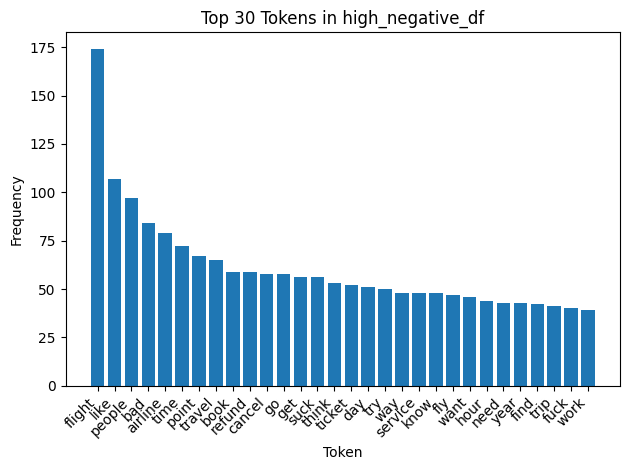

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

#  Flatten your tokens into one long list
all_tokens = [t for toks in high_neg_first_wave_df['tokens'] for t in toks]

#  Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

#  Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_negative_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neg_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neg_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


10526 words total, with a vocabulary size of 2741
Max reddit post length is 133 tokens
Mean reddit post length is 15.39 tokens
Median reddit post length is 11 tokens


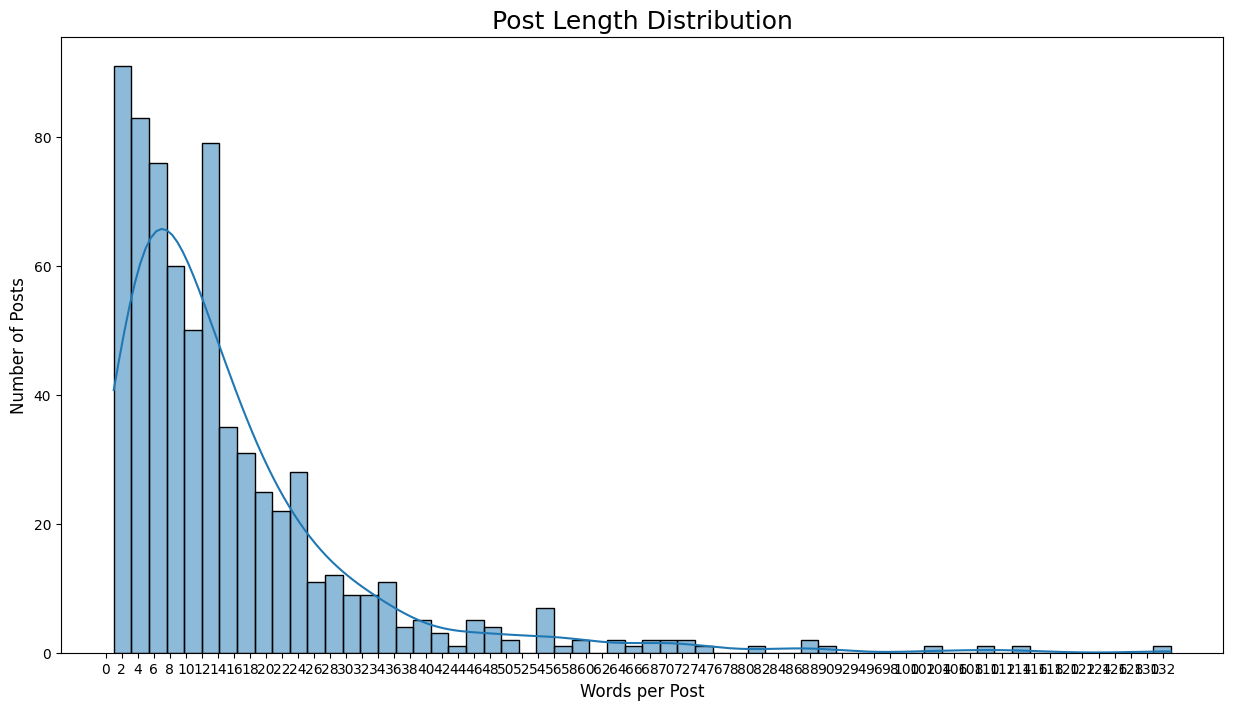

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Prepare your list-of-lists from the `tokens` column
texts = high_neg_first_wave_df['tokens'].tolist()

#  Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

#  Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

#  Apply bigram and trigram transforms
high_neg_first_wave_df['bigram_tokens']   = high_neg_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neg_first_wave_df['trigram_tokens']  = high_neg_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# high_neg_first_wave_df['bigram_text']   = high_neg_first_wave_df['bigram_tokens'].str.join(' ')
# high_neg_first_wave_df['trigram_text']  = high_neg_first_wave_df['trigram_tokens'].str.join(' ')

# Inspect
print(high_neg_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
28702  [stupid, deadline, normally, later, february, ...   
28743                    [bad, case, book, find, cancel]   
28755  [roundtrip, book, mile, jfk, lax, united, febr...   
28769                                    [sad, sad, day]   
28791  [lifemile, fine, time, purchase, ticket, chang...   

                                           bigram_tokens  \
28702  [stupid, deadline, normally, later, february, ...   
28743                    [bad, case, book, find, cancel]   
28755  [roundtrip, book, mile, jfk, lax, united, febr...   
28769                                    [sad, sad, day]   
28791  [lifemile, fine, time, purchase, ticket, chang...   

                                          trigram_tokens  
28702  [stupid, deadline, normally, later, february, ...  
28743                    [bad, case, book, find, cancel]  
28755  [roundtrip, book, mile, jfk, lax, united, febr...  
28769                                    [

In [ ]:
#  Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

#  Flag rows
high_neg_first_wave_df['has_bigrams']  = high_neg_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neg_first_wave_df['has_trigrams'] = high_neg_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

#  Count
rows_with_bigrams  = high_neg_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neg_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neg_first_wave_df['has_bigrams'] & ~high_neg_first_wave_df['has_trigrams']).sum()

#  Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   52
Rows with trigrams:  3
Rows with no n-grams: 632


In [ ]:
high_neg_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28702,2021-01-31,high neg,0.975866,stupid deadline normally later february feel l...,"[stupid, deadline, normally, later, february, ...",stupid deadline normally later february feel l...,"[stupid, deadline, normally, later, february, ...","[stupid, deadline, normally, later, february, ...",False,False
28743,2021-01-29,high neg,0.785879,worst case book find always cancel within hr,"[bad, case, book, find, cancel]",bad case book find cancel,"[bad, case, book, find, cancel]","[bad, case, book, find, cancel]",False,False
28755,2021-01-29,high neg,0.831959,two roundtrips booked tk mile jfk lax united f...,"[roundtrip, book, mile, jfk, lax, united, febr...",roundtrip book mile jfk lax united february ca...,"[roundtrip, book, mile, jfk, lax, united, febr...","[roundtrip, book, mile, jfk, lax, united, febr...",False,False
28769,2021-01-29,high neg,0.913679,sad sad day,"[sad, sad, day]",sad sad day,"[sad, sad, day]","[sad, sad, day]",False,False
28791,2021-01-29,high neg,0.841379,lifemiles fine time purchase ticket change cus...,"[lifemile, fine, time, purchase, ticket, chang...",lifemile fine time purchase ticket change cust...,"[lifemile, fine, time, purchase, ticket, chang...","[lifemile, fine, time, purchase, ticket, chang...",True,False


In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_neg_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neg_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 684
Number of rows in 'trigram_tokenized' column: 684


In [ ]:
import itertools
from collections import Counter

#  Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neg_first_wave_df['trigram_tokens'])

#  Filter for genuine trigrams (
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

#  How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

#  Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 1

Most common trigrams:
pregnant_high_risk: 3


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=2,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=220,
#                                         iterations=100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neg_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 12)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [100,220, 270]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
 for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence', 'alpha', 'eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.2764, Coherence: 0.5109, Alpha: [0.03364679 0.03511371], Eta: [0.83810264 1.2595176  6.3591723  ... 0.56204975 0.56204337 0.56204337]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.2819, Coherence: 0.5452, Alpha: [0.03409821 0.03799803], Eta: [0.8373605  1.257519   6.2019215  ... 0.56165487 0.56165487 0.56165487]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -7.2829, Coherence: 0.5225, Alpha: [0.03638772 0.04163433], Eta: [0.83603483 1.255451   6.0047255  ... 0.56095254 0.5609558  0.5609558 ]
Num Topics: 2, Chunksize: 250, Passes: 220, Iterations: 50, Perplexity: -7.2701, Coherence: 0.5109, Alpha: [0.02636301 0.02770163], Eta: [0.8443496  1.2699497  6.4213433  ... 0.56440467 0.56439745 0.56439745]
Num Topics: 2, Chunksize: 250, Passes: 220, Iterations: 100, Perplexity: -7.2768, Coherence: 0.5175, Alpha: [0.02984711 0.03340652], Eta: [0.8430381 1.2675798 6.3

In [ ]:
#  Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5502
 Perplexity: -7.3591
 Alpha (per topic): [0.03286071 0.02709414 0.06155675]
 Eta   (per word):  [0.4458372  0.52087075 1.2060854  ... 0.33547115 0.3354592  0.3354592 ]


In [ ]:
import numpy as np
from google.colab import files

#  Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

#  Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

#  Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
#  Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.010*"bad" + 0.009*"like" + 0.008*"fuck" + 0.008*"airline" + 0.008*"get" + '
  '0.008*"people" + 0.007*"try" + 0.006*"travel" + 0.006*"point" + '
  '0.005*"hour"'),
 (1,
  '0.008*"flight" + 0.008*"people" + 0.008*"like" + 0.007*"plane" + '
  '0.007*"travel" + 0.006*"test" + 0.006*"find" + 0.005*"bad" + 0.005*"think" '
  '+ 0.005*"time"'),
 (2,
  '0.025*"flight" + 0.010*"refund" + 0.010*"ticket" + 0.009*"book" + '
  '0.009*"cancel" + 0.007*"airline" + 0.007*"like" + 0.007*"people" + '
  '0.007*"time" + 0.006*"suck"')]

Sample doc-topic distribution for doc 0:
[(0, 0.99202704)]


In [ ]:
# pyLDAvis visualization

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  bad (0.0104)
  like (0.0089)
  fuck (0.0082)
  airline (0.0080)
  get (0.0080)
  people (0.0076)
  try (0.0073)
  travel (0.0063)
  point (0.0055)
  hour (0.0050)
  time (0.0047)
  way (0.0044)
  matter (0.0041)
  right (0.0039)
  say (0.0038)
  feel (0.0038)
  know (0.0038)
  day (0.0038)
  think (0.0038)
  call (0.0038)
  post (0.0037)
  year (0.0036)
  need (0.0036)
  shit (0.0036)
  united (0.0035)
  go (0.0033)
  date (0.0033)
  use (0.0032)
  talk (0.0031)
  question (0.0031)

Topic 2:
  flight (0.0084)
  people (0.0084)
  like (0.0079)
  plane (0.0073)
  travel (0.0065)
  test (0.0065)
  find (0.0056)
  bad (0.0053)
  think (0.0051)
  time (0.0050)
  pandemic (0.0050)
  day (0.0044)
  trip (0.0043)
  need (0.0040)
  fly (0.0040)
  airline (0.0039)
  want (0.0038)
  shitty (0.0037)
  covid (0.0037)
  american (0.0036)
  know (0.0036)
  airport (0.0036)
  night (0.0034)
  big (0.0033)
  stop (0.0033)
  pretty (0.0032)
  year (0.0032)
  wa

In [ ]:

# # Visualization (Optional)
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Coherence vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='coherence', hue='chunksize', marker='o')
# plt.title('Coherence Score vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.legend(title='Chunksize')
# plt.show()

# # Perplexity vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='perplexity', hue='chunksize', marker='o')
# plt.title('Perplexity vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Perplexity')
# plt.legend(title='Chunksize')
# plt.show()

# # Coherence vs. Perplexity (Trade-off)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df, x='perplexity', y='coherence', hue='num_topics', style='chunksize', s=100)
# plt.title('Coherence vs Perplexity')
# plt.xlabel('Perplexity')
# plt.ylabel('Coherence Score')
# plt.legend(title='Num Topics')
# plt.show()

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [ ]:
# Extracting and printing the top 30 salient terms for each topic
num_topics = lda_opt.num_topics
num_words = 30

for idx, topic in lda_opt.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
    print(f"Topic {idx + 1}:")
    for word, weight in topic:
        print(f"  {word} ({weight:.4f})")
    print()

Topic 1:
  bad (0.0104)
  like (0.0089)
  fuck (0.0082)
  airline (0.0080)
  get (0.0080)
  people (0.0076)
  try (0.0073)
  travel (0.0063)
  point (0.0055)
  hour (0.0050)
  time (0.0047)
  way (0.0044)
  matter (0.0041)
  right (0.0039)
  say (0.0038)
  feel (0.0038)
  know (0.0038)
  day (0.0038)
  think (0.0038)
  call (0.0038)
  post (0.0037)
  year (0.0036)
  need (0.0036)
  shit (0.0036)
  united (0.0035)
  go (0.0033)
  date (0.0033)
  use (0.0032)
  talk (0.0031)
  question (0.0031)

Topic 2:
  flight (0.0084)
  people (0.0084)
  like (0.0079)
  plane (0.0073)
  travel (0.0065)
  test (0.0065)
  find (0.0056)
  bad (0.0053)
  think (0.0051)
  time (0.0050)
  pandemic (0.0050)
  day (0.0044)
  trip (0.0043)
  need (0.0040)
  fly (0.0040)
  airline (0.0039)
  want (0.0038)
  shitty (0.0037)
  covid (0.0037)
  american (0.0036)
  know (0.0036)
  airport (0.0036)
  night (0.0034)
  big (0.0033)
  stop (0.0033)
  pretty (0.0032)
  year (0.0032)
  way (0.0032)
  mean (0.0031)
  mon

In [13]:
####### HIGH neutral FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neu_first_wave_df = df[df['label'] == 'high neu']

# Convert the 'created_utc' column to datetime
high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])

# Define your date range
start_date = '2020-10-01'
end_date = '2021-01-31'

# Filter the DataFrame for entries within the specified date range
high_neu_first_wave_df = high_neu_first_wave_df[(high_neu_first_wave_df['created_utc'] >= start_date) & (high_neu_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neu_first_wave_df.head()

<ipython-input-13-22f5d2a0fb50>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
28672,2021-01-31,high neu,0.806854,likely may wan na call amex,"[likely, wan, amex]",likely wan amex
28673,2021-01-31,high neu,0.753924,trip delay insurance still viable since cancel...,"[trip, delay, insurance, viable, cancel, card,...",trip delay insurance viable cancel card purchase
28674,2021-01-31,high neu,0.913413,lot web special rts europe summer op willing l...,"[lot, web, special, rt, europe, summer, willin...",lot web special rt europe summer willing littl...
28676,2021-01-31,high neu,0.859335,unless web special price enough rt europe enou...,"[web, special, price, europe, domestic, west, ...",web special price europe domestic west coast a...
28681,2021-01-31,high neu,0.871101,flight dep dtw return msp,"[flight, dep, dtw, return, msp]",flight dep dtw return msp


In [14]:
high_neu_first_wave_df.shape[0]

4588

       token  count
0     flight    897
1      point    755
2       book    724
3      night    671
4    airline    425
5      check    420
6        day    413
7       need    409
8     travel    376
9        fly    361
10      stay    355
11     award    338
12      time    336
13      card    328
14      like    318
15      year    309
16      look    308
17    ticket    305
18      mile    289
19       use    288
20     hyatt    272
21     think    264
22    change    262
23      know    248
24     hotel    248
25  transfer    240
26       pay    230
27       way    222
28      trip    216
29       try    216


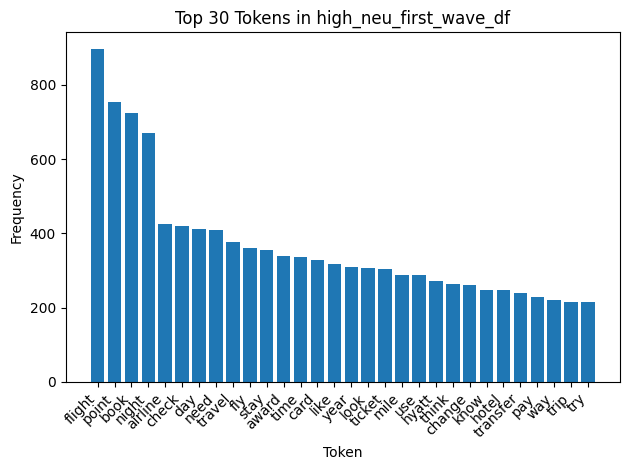

In [15]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

#  Flatten your tokens into one long list
all_tokens = [t for toks in high_neu_first_wave_df['tokens'] for t in toks]

#  Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

#  Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

#  Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_neu_first_wave_df')
plt.tight_layout()
plt.show()

In [16]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neu_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neu_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


58138 words total, with a vocabulary size of 6253
Max reddit post length is 274 tokens
Mean reddit post length is 12.67 tokens
Median reddit post length is 9 tokens


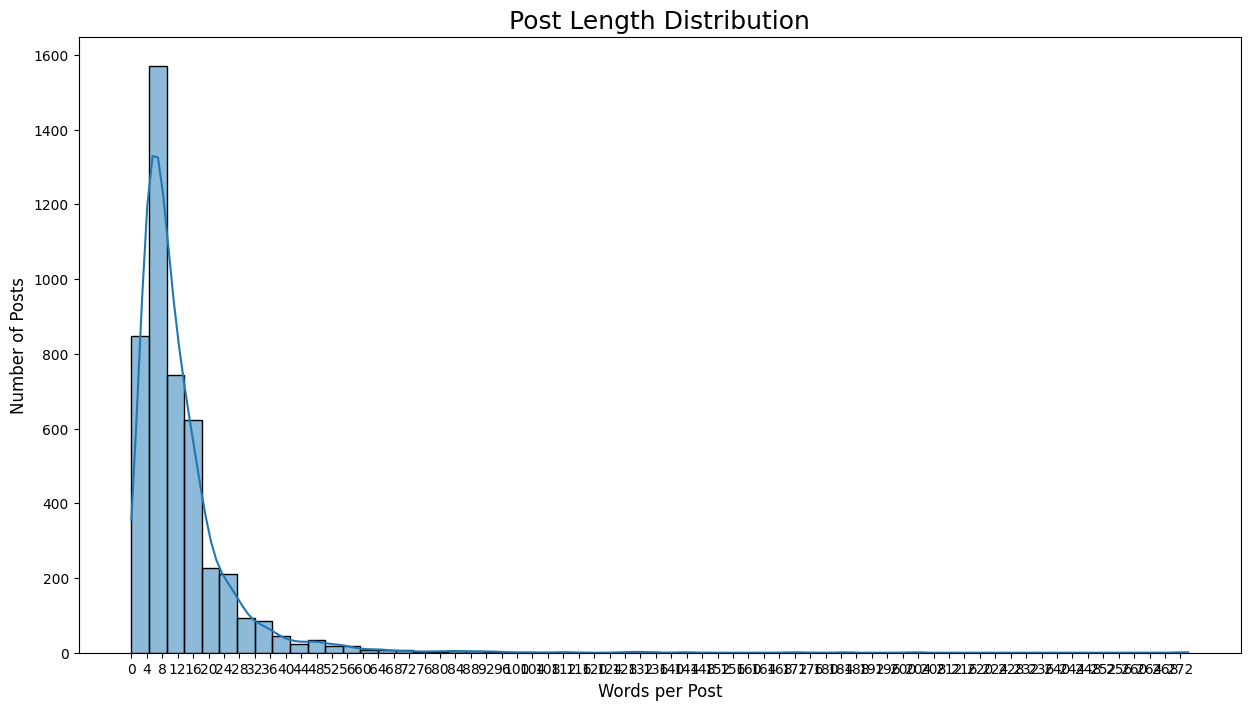

In [17]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

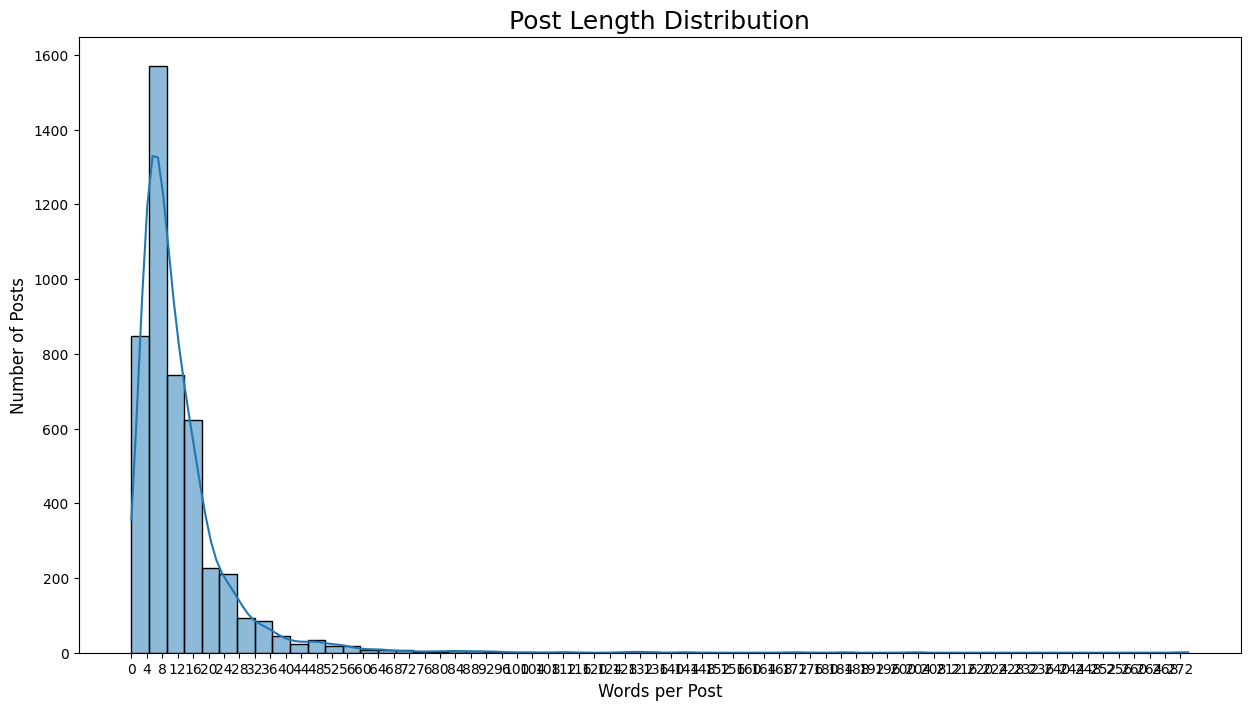

In [18]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [19]:
!pip install gensim

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [20]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neu_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neu_first_wave_df['bigram_tokens']   = high_neu_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neu_first_wave_df['trigram_tokens']  = high_neu_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])


# high_neu_first_wave_df['bigram_text']   = high_neu_first_wave_df['bigram_tokens'].str.join(' ')
# high_neu_first_wave_df['trigram_text']  = high_neu_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neu_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
28672                                [likely, wan, amex]   
28673  [trip, delay, insurance, viable, cancel, card,...   
28674  [lot, web, special, rt, europe, summer, willin...   
28676  [web, special, price, europe, domestic, west, ...   
28681                    [flight, dep, dtw, return, msp]   

                                           bigram_tokens  \
28672                                [likely, wan, amex]   
28673  [trip, delay, insurance, viable, cancel, card,...   
28674  [lot, web_special, rt, europe, summer, willing...   
28676  [web_special, price, europe, domestic, west_co...   
28681                    [flight, dep, dtw, return, msp]   

                                          trigram_tokens  
28672                                [likely, wan, amex]  
28673  [trip, delay, insurance, viable, cancel, card,...  
28674  [lot, web_special, rt, europe, summer, willing...  
28676  [web_special, price, europe, domest

In [21]:
#  Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

#  Flag rows
high_neu_first_wave_df['has_bigrams']  = high_neu_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neu_first_wave_df['has_trigrams'] = high_neu_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

#  Count
rows_with_bigrams  = high_neu_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neu_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neu_first_wave_df['has_bigrams'] & ~high_neu_first_wave_df['has_trigrams']).sum()

#  Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   871
Rows with trigrams:  20
Rows with no n-grams: 3717


In [22]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28672,2021-01-31,high neu,0.806854,likely may wan na call amex,"[likely, wan, amex]",likely wan amex,"[likely, wan, amex]","[likely, wan, amex]",False,False
28673,2021-01-31,high neu,0.753924,trip delay insurance still viable since cancel...,"[trip, delay, insurance, viable, cancel, card,...",trip delay insurance viable cancel card purchase,"[trip, delay, insurance, viable, cancel, card,...","[trip, delay, insurance, viable, cancel, card,...",False,False
28674,2021-01-31,high neu,0.913413,lot web special rts europe summer op willing l...,"[lot, web, special, rt, europe, summer, willin...",lot web special rt europe summer willing littl...,"[lot, web_special, rt, europe, summer, willing...","[lot, web_special, rt, europe, summer, willing...",True,False
28676,2021-01-31,high neu,0.859335,unless web special price enough rt europe enou...,"[web, special, price, europe, domestic, west, ...",web special price europe domestic west coast a...,"[web_special, price, europe, domestic, west_co...","[web_special, price, europe, domestic, west_co...",True,False
28681,2021-01-31,high neu,0.871101,flight dep dtw return msp,"[flight, dep, dtw, return, msp]",flight dep dtw return msp,"[flight, dep, dtw, return, msp]","[flight, dep, dtw, return, msp]",False,False


In [23]:
# Print the total number of rows in the DataFrame
total_rows = high_neu_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neu_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 4588
Number of rows in 'trigram_tokenized' column: 4588


In [24]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neu_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigram
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 10

Most common trigrams:
rtpcr_test_require: 6
star_alliance_partner: 4
transfer_follow_yellow: 4
center_hyatt_regency: 3
click_link_remind: 3
west_coast_hawaii: 3
dfw_clt_clt: 3
resort_amp_spa: 3
self_parking_garage: 3
wear_face_mask: 3


In [25]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
#id2word.filter_extremes(no_below=5, no_above=0.5)

#
#id2word.compactify()

# 2. Convert each document to a Bag-of-Words
texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1)]


In [26]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=100,
#                                       iterations=100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [27]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [28]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28672,2021-01-31,high neu,0.806854,likely may wan na call amex,"[likely, wan, amex]",likely wan amex,"[likely, wan, amex]","[likely, wan, amex]",False,False
28673,2021-01-31,high neu,0.753924,trip delay insurance still viable since cancel...,"[trip, delay, insurance, viable, cancel, card,...",trip delay insurance viable cancel card purchase,"[trip, delay, insurance, viable, cancel, card,...","[trip, delay, insurance, viable, cancel, card,...",False,False
28674,2021-01-31,high neu,0.913413,lot web special rts europe summer op willing l...,"[lot, web, special, rt, europe, summer, willin...",lot web special rt europe summer willing littl...,"[lot, web_special, rt, europe, summer, willing...","[lot, web_special, rt, europe, summer, willing...",True,False
28676,2021-01-31,high neu,0.859335,unless web special price enough rt europe enou...,"[web, special, price, europe, domestic, west, ...",web special price europe domestic west coast a...,"[web_special, price, europe, domestic, west_co...","[web_special, price, europe, domestic, west_co...",True,False
28681,2021-01-31,high neu,0.871101,flight dep dtw return msp,"[flight, dep, dtw, return, msp]",flight dep dtw return msp,"[flight, dep, dtw, return, msp]","[flight, dep, dtw, return, msp]",False,False


In [29]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neu_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [30]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [31]:
## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 12)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50,  100, 200]
iterations_range = [50,  100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta,seed))
    #print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}. Alpha: {alpha},  Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")


Results:
     num_topics  chunksize  passes  iterations  perplexity  coherence  \
0             2        250      50          50   -7.396356   0.677399   
1             2        250      50         100   -7.396024   0.677399   
2             2        250      50         200   -7.396132   0.677399   
3             2        250     100          50   -7.349183   0.643314   
4             2        250     100         100   -7.347882   0.643314   
..          ...        ...     ...         ...         ...        ...   
265          11        250     100         100   -8.221954   0.405102   
266          11        250     100         200   -8.211694   0.396084   
267          11        250     200          50   -8.120603   0.411796   
268          11        250     200         100   -8.129260   0.396952   
269          11        250     200         200   -8.114139   0.394664   

                                                 alpha  \
0                               [0.732758, 0.20466092] 

In [32]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.6774
 Perplexity: -7.3961
 Alpha (per topic): [0.72404855 0.20095532]
 Eta   (per word):  [0.9733566  1.7437723  0.4425681  ... 0.42409113 0.38174802 0.3817582 ]


In [33]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [35]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.023*"flight" + 0.014*"airline" + 0.011*"book" + 0.010*"check" + '
  '0.009*"fly" + 0.009*"travel" + 0.009*"need" + 0.009*"ticket" + 0.008*"day" '
  '+ 0.007*"airport"'),
 (1,
  '0.034*"point" + 0.026*"night" + 0.020*"stay" + 0.016*"card" + 0.014*"hotel" '
  '+ 0.014*"credit" + 0.009*"hyatt" + 0.008*"year" + 0.008*"room" + '
  '0.007*"cash"')]

Sample doc-topic distribution for doc 0:
[(0, 0.66314256), (1, 0.3368574)]


In [36]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [37]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  flight (0.0229)
  airline (0.0135)
  book (0.0106)
  check (0.0103)
  fly (0.0090)
  travel (0.0088)
  need (0.0088)
  ticket (0.0085)
  day (0.0082)
  airport (0.0069)
  time (0.0066)
  bag (0.0054)
  look (0.0054)
  change (0.0051)
  ask (0.0049)
  like (0.0049)
  know (0.0043)
  hour (0.0042)
  seat (0.0042)
  test (0.0041)
  country (0.0041)
  sure (0.0040)
  able (0.0040)
  way (0.0039)
  month (0.0039)
  allow (0.0039)
  transit (0.0039)
  go (0.0038)
  covid (0.0037)
  refund (0.0036)

Topic 2:
  point (0.0342)
  night (0.0259)
  stay (0.0201)
  card (0.0158)
  hotel (0.0141)
  credit (0.0140)
  hyatt (0.0086)
  year (0.0084)
  room (0.0077)
  cash (0.0075)
  use (0.0069)
  book (0.0062)
  pay (0.0062)
  status (0.0062)
  spend (0.0058)
  free (0.0051)
  rate (0.0051)
  property (0.0050)
  think (0.0048)
  hilton (0.0041)
  end (0.0040)
  marriott (0.0040)
  earn (0.0037)
  post (0.0037)
  need (0.0036)
  value (0.0036)
  amex (0.0034)


In [38]:
# # Visualization (Optional)
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Coherence vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='coherence', hue='chunksize', marker='o')
# plt.title('Coherence Score vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.legend(title='Chunksize')
# plt.show()

# # Perplexity vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='perplexity', hue='chunksize', marker='o')
# plt.title('Perplexity vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Perplexity')
# plt.legend(title='Chunksize')
# plt.show()

# # Coherence vs. Perplexity (Trade-off)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df, x='perplexity', y='coherence', hue='num_topics', style='chunksize', s=100)
# plt.title('Coherence vs Perplexity')
# plt.xlabel('Perplexity')
# plt.ylabel('Coherence Score')
# plt.legend(title='Num Topics')
# plt.show()


In [39]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [40]:
import gensim.corpora as corpora

# 1. Create Dictionary from trigram tokens
id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

# 2. Prune extremes
id2word.filter_extremes(no_below=5, no_above=0.7)

# 3. (Optional) Re-map token IDs to remove gaps
id2word.compactify()

# 4. Convert each document to Bag-of-Words using the pruned dictionary
texts = high_neu_first_wave_df['trigram_tokens'].tolist()
corpus = [id2word.doc2bow(text) for text in texts]

# 5. View the first doc's BoW after pruning
print(corpus[:1][0][:30])


[(0, 1), (1, 1)]


In [41]:
## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 6)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50,  100, 200]
iterations_range = [50,  100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta))
    #print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}. Alpha: {alpha},  Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")


Results:
    num_topics  chunksize  passes  iterations  perplexity  coherence  \
0            2        250      50          50   -6.766446   0.541401   
1            2        250      50         100   -6.766026   0.541401   
2            2        250      50         200   -6.766117   0.541401   
3            2        250     100          50   -6.743050   0.540230   
4            2        250     100         100   -6.743782   0.541618   
5            2        250     100         200   -6.743753   0.541618   
6            2        250     200          50   -6.726349   0.534592   
7            2        250     200         100   -6.726379   0.534592   
8            2        250     200         200   -6.726375   0.534592   
9            3        250      50          50   -6.832260   0.565378   
10           3        250      50         100   -6.846797   0.576555   
11           3        250      50         200   -6.790076   0.550137   
12           3        250     100          50   -6.800

In [42]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Fit the LDA model using the pruned dictionary and corpus
lda_opt = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=optimal_num_topics,
    chunksize=optimal_chunksize,
    passes=optimal_passes,
    iterations=optimal_iterations,
    alpha= 'auto',
    eta='auto',
    random_state=100,
    per_word_topics=True
)

# Extract evaluation metrics
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=id2word, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

# Print metrics
print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.4500
 Perplexity: -6.6658
 Alpha (per topic): [1.3542519 1.9064573 1.1955678 2.9000769 2.0640802]
 Eta   (per word):  [0.14823058 0.15038158 0.15067051 ... 0.13939439 0.1384054  0.14141497]


In [43]:
import numpy as np
from google.colab import files

#  Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

#  Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")


files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [45]:
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


pyLDAvis.enable_notebook()


In [46]:
print("=== Topics ===")
pprint(lda_opt.print_topics())  # Uses the updated lda_opt

# Document-topic distribution
doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]

print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])


=== Topics ===
[(0,
  '0.037*"change" + 0.029*"month" + 0.027*"refund" + 0.023*"option" + '
  '0.021*"trip" + 0.020*"come" + 0.019*"people" + 0.019*"work" + '
  '0.016*"booking" + 0.016*"new"'),
 (1,
  '0.053*"point" + 0.040*"night" + 0.031*"stay" + 0.024*"card" + 0.024*"go" + '
  '0.024*"year" + 0.022*"hotel" + 0.022*"credit" + 0.021*"pay" + 0.015*"get"'),
 (2,
  '0.072*"check" + 0.038*"bag" + 0.026*"covid" + 0.023*"enter" + '
  '0.021*"require" + 0.021*"question" + 0.016*"visa" + 0.015*"state" + '
  '0.014*"requirement" + 0.014*"air"'),
 (3,
  '0.041*"book" + 0.033*"need" + 0.030*"travel" + 0.028*"day" + 0.023*"time" + '
  '0.019*"like" + 0.018*"look" + 0.016*"ask" + 0.016*"know" + 0.016*"think"'),
 (4,
  '0.093*"flight" + 0.055*"airline" + 0.036*"fly" + 0.034*"ticket" + '
  '0.028*"airport" + 0.017*"hour" + 0.017*"seat" + 0.017*"test" + 0.017*"way" '
  '+ 0.016*"transit"')]

Sample doc-topic distribution for doc 0:
[(0, 0.20614007),
 (1, 0.25446942),
 (2, 0.10469418),
 (3, 0.2539505

In [47]:
# Prepare the visualization using the pruned dictionary and LDA model
vis_data = gensimvis.prepare(
    topic_model=lda_opt,
    corpus=corpus,
    dictionary=id2word,
    sort_topics=False
)

#
pyLDAvis.display(vis_data)


In [48]:
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):

    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  change (0.0374)
  month (0.0285)
  refund (0.0267)
  option (0.0228)
  trip (0.0206)
  come (0.0205)
  people (0.0195)
  work (0.0194)
  booking (0.0163)
  new (0.0160)
  policy (0.0155)
  cancel (0.0154)
  likely (0.0142)
  far (0.0139)
  issue (0.0135)
  reason (0.0127)
  cheap (0.0119)
  plan (0.0118)
  reservation (0.0114)
  email (0.0111)
  upgrade (0.0111)
  cost (0.0105)
  happen (0.0100)
  information (0.0093)
  standard (0.0090)
  experience (0.0089)
  hilton (0.0087)
  help (0.0087)
  lot (0.0086)
  send (0.0078)

Topic 2:
  point (0.0527)
  night (0.0400)
  stay (0.0310)
  card (0.0243)
  go (0.0236)
  year (0.0236)
  hotel (0.0217)
  credit (0.0216)
  pay (0.0213)
  get (0.0148)
  return (0.0133)
  hyatt (0.0132)
  fee (0.0129)
  post (0.0121)
  room (0.0118)
  cash (0.0115)
  end (0.0115)
  usually (0.0114)
  status (0.0096)
  offer (0.0095)
  spend (0.0089)
  start (0.0088)
  assume (0.0088)
  wait (0.0087)
  ill (0.0084)
  add (

In [49]:
lda_opt.save('/content/drive/MyDrive/lda_model_neu_2st_wave_pruned.gensim')